In [ ]:
# Import a bunch
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Input, BatchNormalization
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
from glob import glob
import shutil
import pathlib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Install kaggle
! pip install -q kaggle
#Upload json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datnguyn","key":"33189a7435be2df265a50d894f6f7868"}'}

In [ ]:
#Download dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [01:12<00:00, 60.3MB/s]
100% 5.20G/5.20G [01:12<00:00, 77.0MB/s]


In [ ]:
# Unzip data
!unzip /content/skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

In [ ]:
# Move to data folder
!mkdir ../data
!mv /content/HAM10000_images_part_1 ../data
!mv /content/HAM10000_images_part_2 ../data

In [ ]:
#Get all the image path
data_dir = '/data'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
len(all_image_path)

10015

In [ ]:
! mkdir ../project
! mkdir ../project/data
! mkdir ../project/data/train
! mkdir ../project/data/test
! mkdir ../project/raw_data

In [ ]:
# Get dataframe from csv
df = pd.read_csv('/content/HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
# Get information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
# Fill in missing value
from statistics import median
df['age'] = df['age'].fillna(median(df['age']))

In [ ]:
# Describe data
df.describe(include='all')

lesion_id      image_id     dx  ...           age    sex localization
count         10015         10015  10015  ...  10015.000000  10015        10015
unique         7470         10015      7  ...           NaN      3           15
top     HAM_0003789  ISIC_0025996     nv  ...           NaN   male         back
freq              6             1   6705  ...           NaN   5406         2192
mean            NaN           NaN    NaN  ...     51.824763    NaN          NaN
std             NaN           NaN    NaN  ...     16.928129    NaN          NaN
min             NaN           NaN    NaN  ...      0.000000    NaN          NaN
25%             NaN           NaN    NaN  ...     40.000000    NaN          NaN
50%             NaN           NaN    NaN  ...     50.000000    NaN          NaN
75%             NaN           NaN    NaN  ...     65.000000    NaN          NaN
max             NaN           NaN    NaN  ...     85.000000    NaN          NaN

[11 rows x 7 columns]

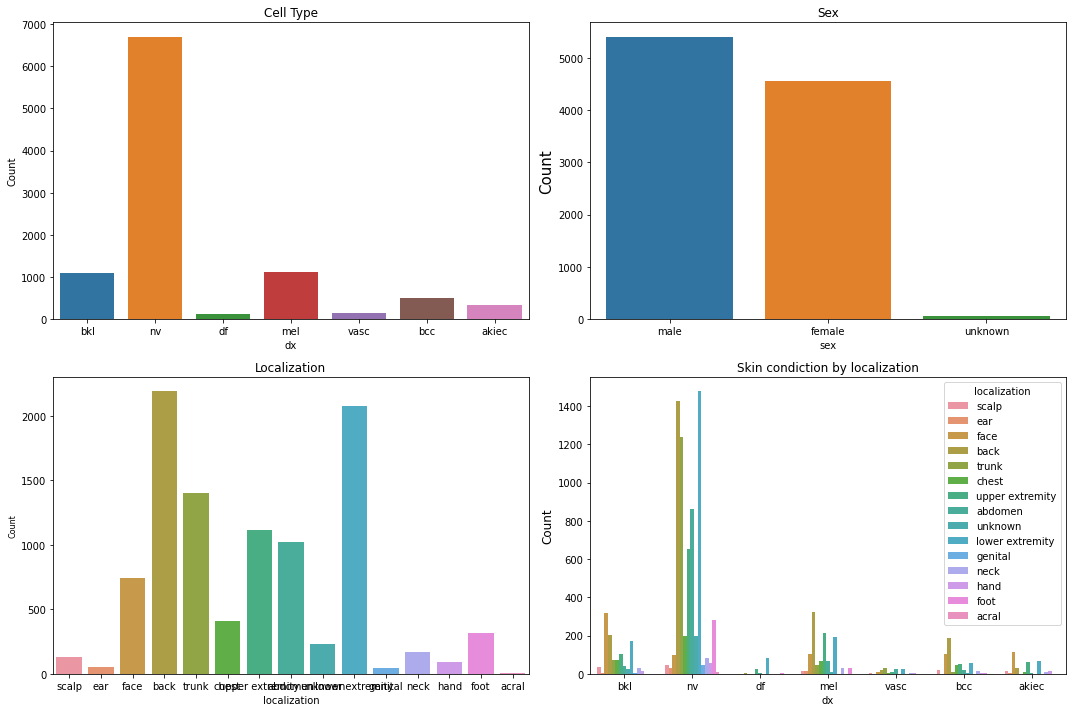

In [ ]:
#EDA
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
sns.countplot(df['dx'])
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
sns.countplot(df['sex'])
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
sns.countplot(df['localization'])
ax3.set_ylabel('Count',size=8)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sns.countplot(df['dx'], hue=df['localization'])
ax4.set_ylabel('Count',size=12)
ax4.set_title('Skin condiction by localization')

plt.tight_layout()
plt.show()

In [ ]:
# Get all the label
label = list(df['dx'].unique())
label

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

In [ ]:
# Skin cancer condition dictionaries
cancer_type_dict = {
    'bkl': 'Benign keratosis-like lesions ',
    'nv': 'Melanocytic nevi',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'vasc': 'Vascular lesions',  
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses'
}

In [ ]:
label_to_index = {
    'bkl': 0,
    'nv': 1,
    'df': 2,
    'mel': 3,
    'vasc': 4,  
    'bcc': 5,
    'akiec': 6
}

In [ ]:
# Join 2 folder into a single folder
src1 = '/data/HAM10000_images_part_1'
src_files1 = os.listdir(src1)
destination = '/project/raw_data'
source1 = '/data/HAM10000_images_part_1'
for image in src_files1:
  shutil.copy((src1 + '/' + image),(destination + '/' + image))

src2 = '/data/HAM10000_images_part_2'
src_files2 = os.listdir(src2)
source2 = '/data/HAM10000_images_part_2'
for image in src_files2:
  shutil.copy((source2 + '/' + image), (destination + '/' + image))

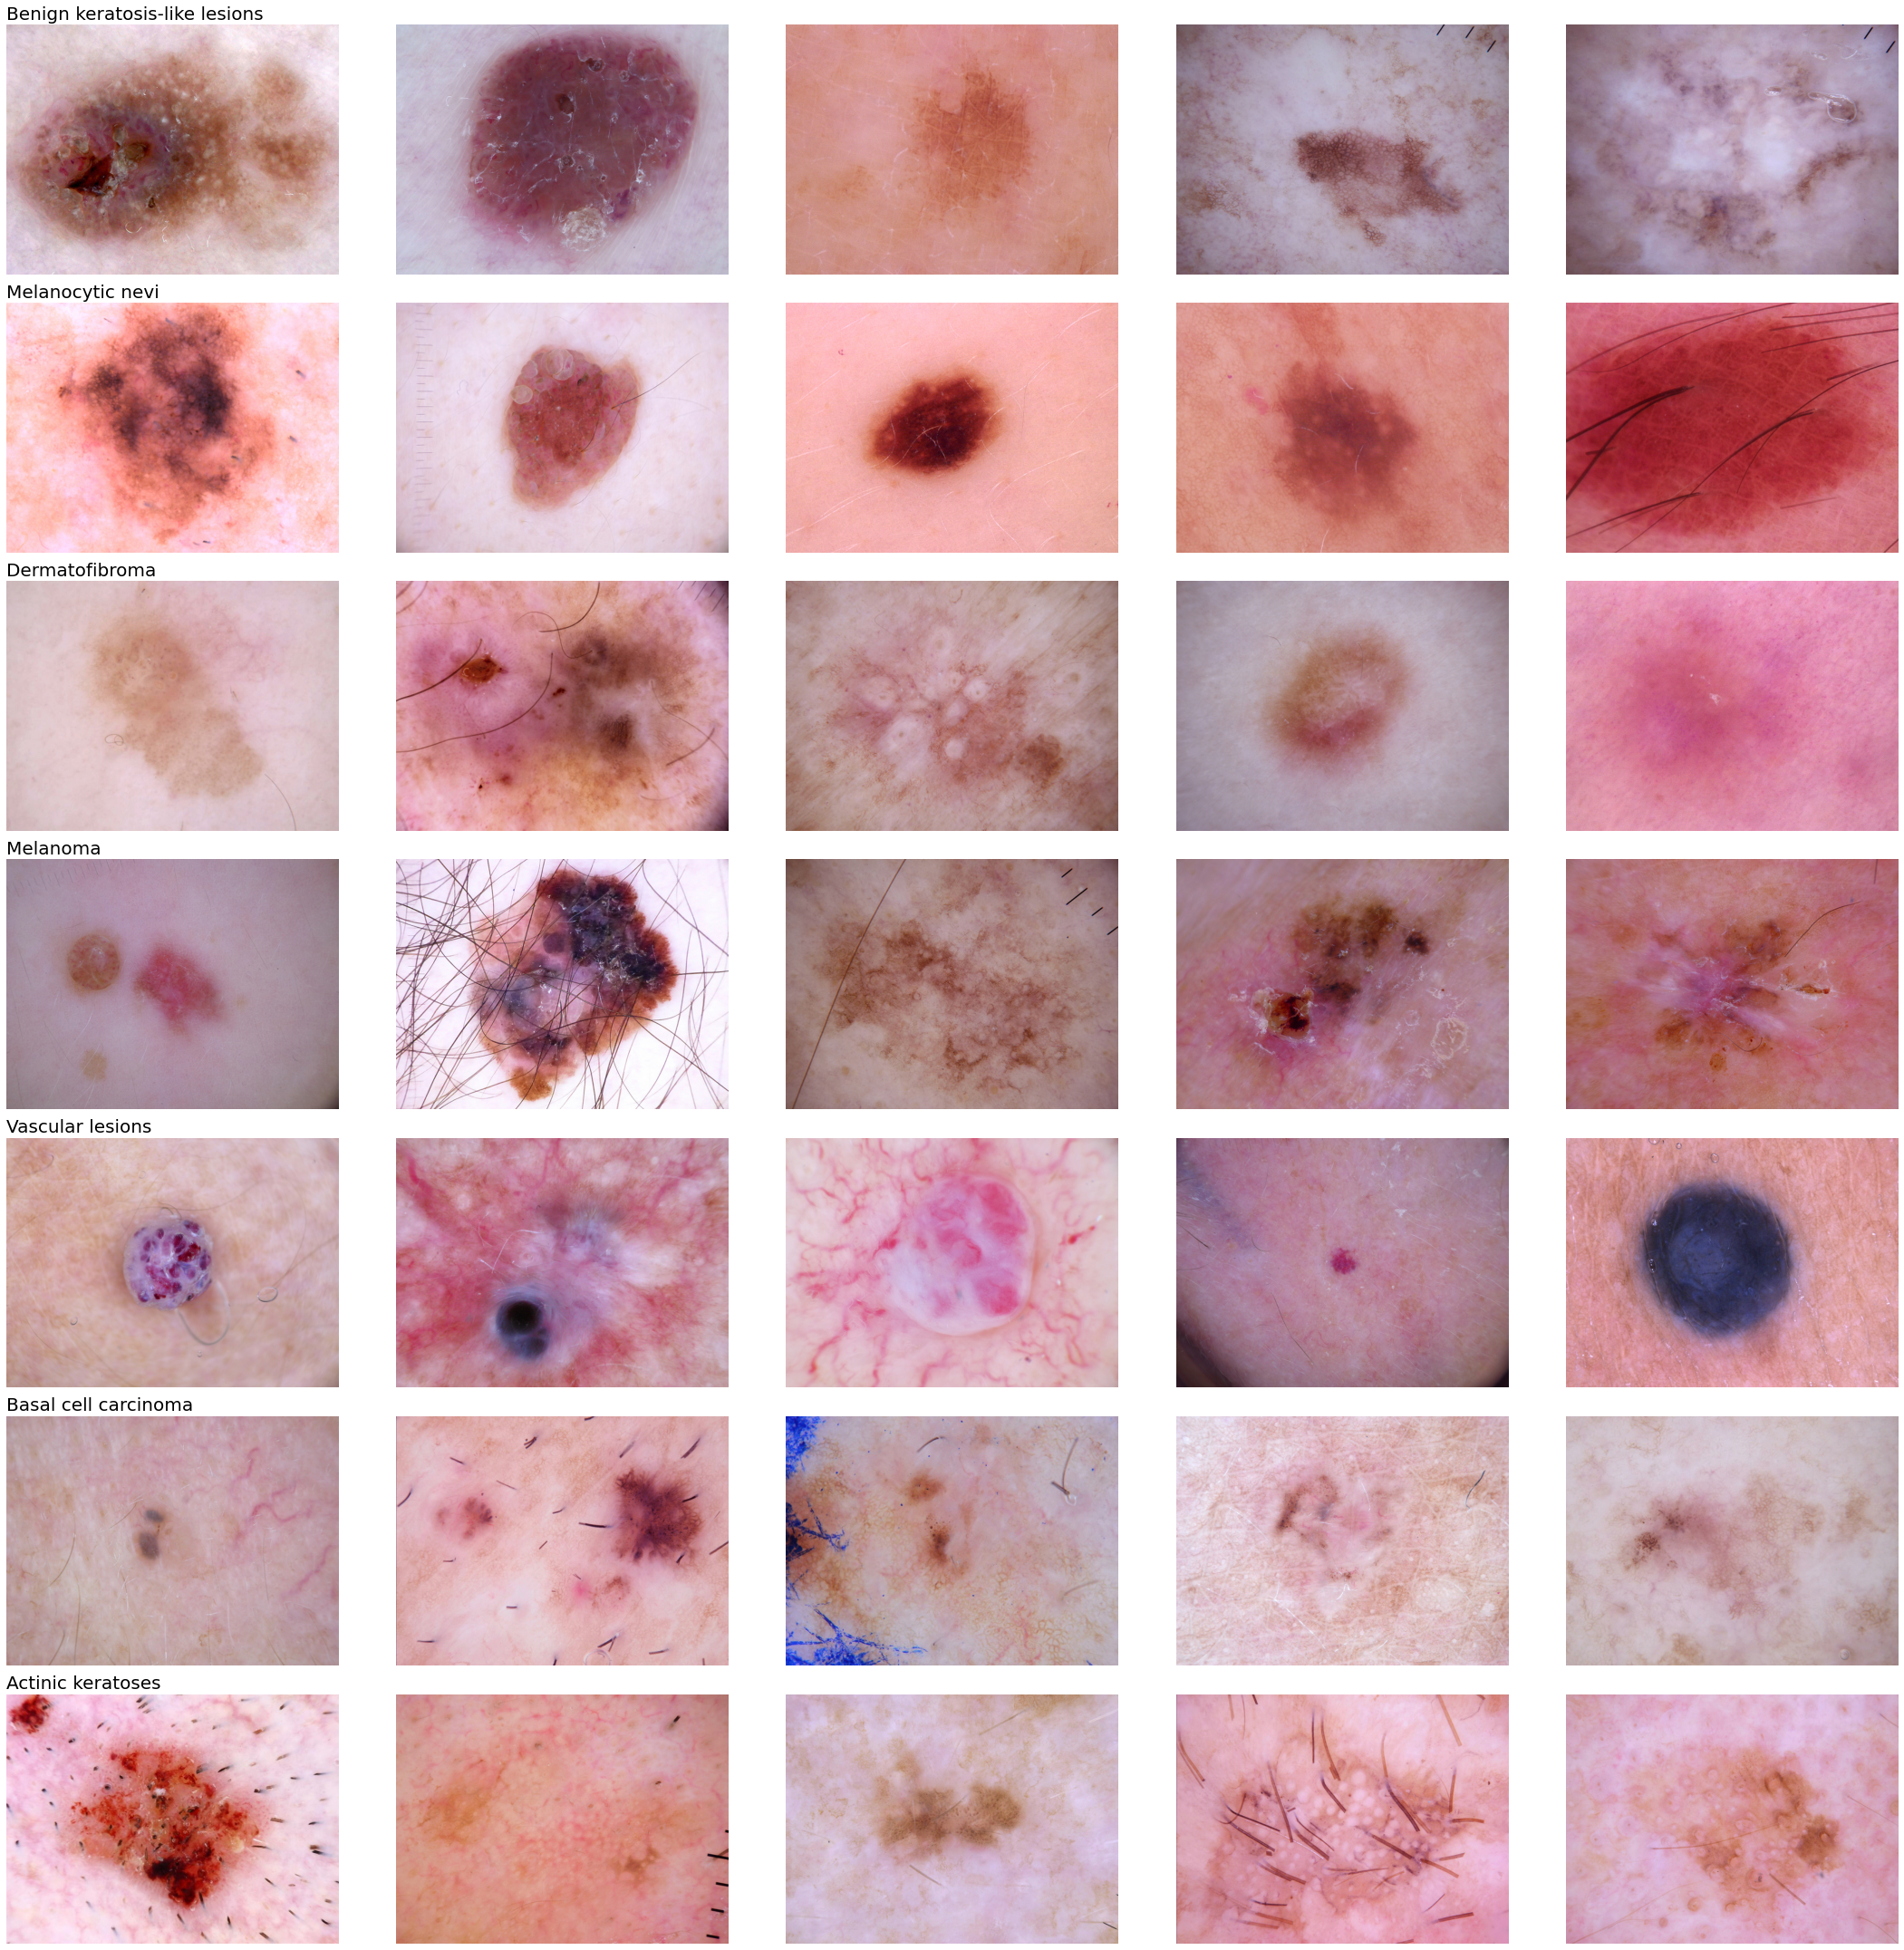

In [ ]:
# Show image of certain skin deseases
destination = '/project/raw_data'
fig = plt.figure(figsize=(30, 30))
k = range(7)
rand_image = []
for i in label:
    sample = df[df['dx'] == i]['image_id'].sample(5)
    rand_image.extend(sample)
    
for position,ID in enumerate(rand_image):
    labl = df[df['image_id'] == ID]['dx']
    rand_img = destination + "/" + f'/{ID}.jpg'
    rand_img = mpimg.imread(rand_img)

    plt.subplot(7,5,position+1)
    plt.imshow(rand_img)
    plt.axis('off')

    if position%5 == 0:
        title = int(position/5)
        plt.title(cancer_type_dict[label[int(position/5)]], loc='left', size=20)

plt.tight_layout()
plt.show()

In [ ]:
# Spliting the train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1)

In [ ]:
#Split into specific categories
source_dir = '/project/raw_data'
dest_dir = '/project/data'
def split_categories(file, dataframe):
  for i in label:
    sample = []
    os.mkdir(dest_dir + "/" + str(file) + "/" + str(i))
    sample = list(dataframe[dataframe['dx'] == i]['image_id'])
    for j in sample:
      shutil.copyfile((source_dir + '/' + j +".jpg"), (dest_dir + "/" + str(file) + "/" + i + '/' + j + ".jpg"))

# Move to train folder
split_categories('train',train)

# Move to test folder
split_categories('test',test)

print('Train size is: ' + str(len(glob(os.path.join('/project/data/train', '*', '*.jpg')))))
print('Test size is: ' + str(len(glob(os.path.join('/project/data/test', '*', '*.jpg')))))

Train size is: 9013
Test size is: 1002


In [ ]:
train_folder = pathlib.Path('/project/data/train')
test_folder = pathlib.Path('/project/data/test')
all_train_paths = [str(item) for item in train_folder.glob('*/*') if item.is_file()]
all_train_labels = [label_to_index[str(item.parent.name)] for item in train_folder.glob('*/*') if item.is_file()]

all_test_paths = [str(item) for item in test_folder.glob('*/*') if item.is_file()]
all_test_labels = [label_to_index[str(item.parent.name)] for item in test_folder.glob('*/*') if item.is_file()]

In [ ]:
def processing_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image,[192,192])
  image /= 255.0
  return image

def load_and_process_image(image_path):
  image = tf.io.read_file(image_path)
  return processing_image(image)

#def augmentation(image, label):
#    image = tf.image.random_brightness(image, .1)
#    image = tf.image.random_contrast(image, lower=0.0, upper=.2)
#    image = tf.image.random_saturation(image, lower=0.0, upper=.2)
#    image = tf.image.random_flip_left_right(image)
#    image = tf.image.random_flip_up_down(image)
#    return image, label

def load_and_process_image_with_label(path, label):
  return load_and_process_image(path), label

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((all_train_paths,all_train_labels))
train_ds = tf.data.Dataset.from_tensor_slices((all_test_paths,all_test_labels))

ds_map_cache = ds.map(load_and_process_image_with_label).cache()
train_ds_map_cache = train_ds.map(load_and_process_image_with_label).cache()

In [ ]:
train_data_set = ds_map_cache
test_data_set = train_ds_map_cache
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

SHUFFLE_BUFFER_SIZE= 1024
final_train_dataset = train_data_set.repeat().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
final_test_dataset = test_data_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}.h5',
        save_best_only = True,
        verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience =5,restore_best_weights=True)

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(7, activation = 'softmax')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               327936    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 7)                

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
steps_per_epoch=tf.math.ceil(len(all_train_paths)/BATCH_SIZE).numpy()
history = model.fit(final_train_dataset,validation_data=final_test_dataset, epochs=20, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.7753
Epoch 00001: val_loss did not improve from 0.94770
282/282 [==============================] - 250s 886ms/step - loss: 0.6464 - accuracy: 0.7753 - val_loss: 1.1385 - val_accuracy: 0.6238
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.8139
Epoch 00002: val_loss did not improve from 0.94770
282/282 [==============================] - 249s 882ms/step - loss: 0.5341 - accuracy: 0.8139 - val_loss: 1.1050 - val_accuracy: 0.6417
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.8317
Epoch 00003: val_loss did not improve from 0.94770
282/282 [==============================] - 250s 887ms/step - loss: 0.4911 - accuracy: 0.8317 - val_loss: 1.0220 - val_accuracy: 0.6697
Epoch 4/20
282/282 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.8400
Epoch 00004: val_loss did not improve from 0.94770
282/282

In [ ]:
model.save('model.h5')

In [ ]:
def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

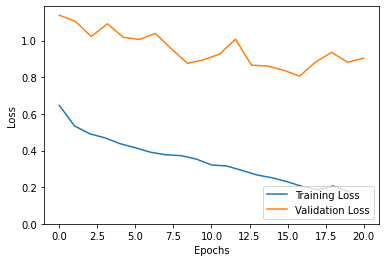

In [ ]:
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')

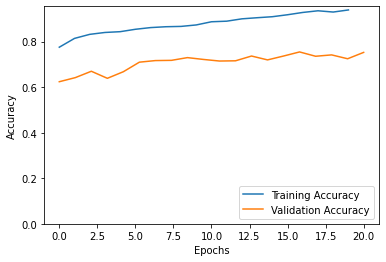

In [ ]:
plot_stats(history.history['accuracy'], history.history['val_accuracy'], x_label='Epochs', stats='accuracy')

In [ ]:
reloaded_model = tf.keras.models.load_model('/content/mymodel_16.h5')
reloaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               327936    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 7)                

In [ ]:
def show_batch(image_batch, label_batch):
    '''Show batch of 25 images.
    
    Parameters:
        image_batch: paths to the images, len(image_path) >= 25
        label_batch: labels of the images (str)
    '''
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].title())
        plt.axis('off')

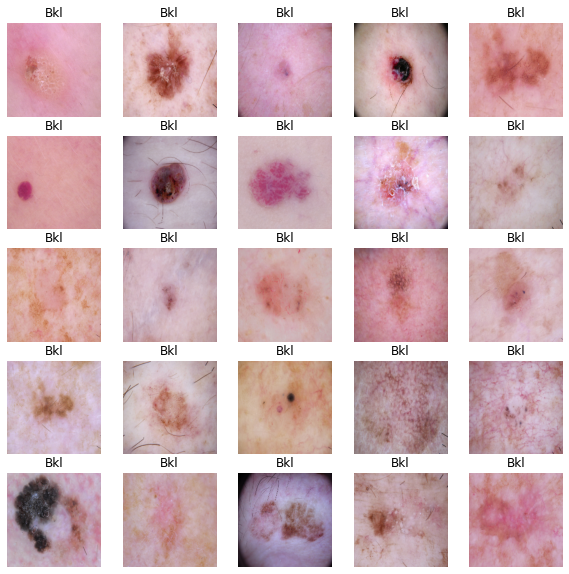

In [ ]:
image_batch, label_batch = next(iter(final_train_dataset))
label_batch = [label[np.argmax(id)] for id in label_batch.numpy()]
show_batch(image_batch, label_batch)

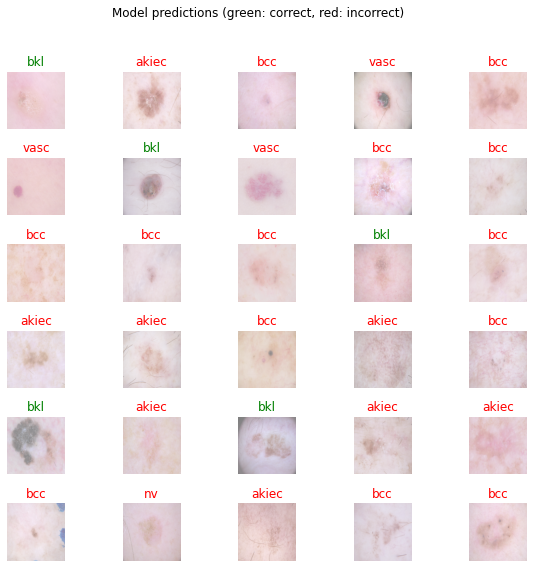

In [ ]:
predicted_batch = reloaded_model.predict(image_batch)
predicted_label = np.argmax(predicted_batch, axis=1)
predicted_label = [label[idx] for idx in predicted_label]
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow((image_batch[n]+1)/2)
    color = "green" if predicted_label[n] == label_batch[n] else "red"
    plt.title(predicted_label[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")